# Flight Time Modeling

This notebook visualizes and predicts the flight times of domestic flights. 

## Importing, Cleaning and Visualizing

In [1]:
import glob
import numpy as np 
import sklearn
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Importing the Data

All of the data from the Department of Transportation comes in directories like `data_YYYY_MM/data_YYYY_MM.csv`. So for each year, there are 12 unique csv files to be loaded. Here, we're loading just the january data from all the available years and combining it into one dataframe.  

In [2]:
january_data = glob.glob('CarrierData/*/*_1.csv')

loaded_data = []

for path in january_data:
    this_data = pd.read_csv(path, skipinitialspace=True, low_memory=False)
    loaded_data.append(this_data)

df = pd.concat(loaded_data)

The airlines are represented as unique codes, so we need to import the lookup table from the DoT and create a dictionary.

In [3]:
this_data = pd.read_csv('CarrierData/carriers.csv', skipinitialspace=True, low_memory=False)

airlines_lookup = this_data.set_index('Code')['Description'].to_dict()

### Cleaning the Data

Consolidating the dataframe to just contian the relevant columns:

In [4]:
df = df[['FlightDate','Reporting_Airline', 'Origin', 'OriginCityName', 'Dest', 'DestCityName', 'DepDelay',
         'TaxiOut', 'TaxiIn', 'ArrDelay', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime']]

There might be some missing data, so let's visualize that here. 

In [5]:
missing = df.isnull().sum(axis=0).reset_index()
missing.columns = ['Variable', 'Missing Entries']
missing['Percent Complete'] = (df.shape[0] - missing['Missing Entries']) / df.shape[0]*100
missing.sort_values('Percent Complete').reset_index(drop = True)

,Variable,Missing Entries,Percent Complete
0,ArrDelay,54476,97.186055
1,ActualElapsedTime,54274,97.196490
2,AirTime,54274,97.196490
3,TaxiIn,50984,97.366434
4,TaxiOut,49312,97.452800
5,DepDelay,48994,97.469227
6,CRSElapsedTime,4,99.999793
7,FlightDate,0,100.000000
8,Reporting_Airline,0,100.000000
9,Origin,0,100.000000


Since the dataset is about 97% complete, we'll just drop any rows that are missing data. It won't result in too much of a loss.

In [6]:
before = len(df.index)
df.dropna(inplace = True)
after = len(df.index)

diff = before - after

print("Removed {} entries out of {}".format(diff, before))

Removed 54952 entries out of 1935930


### Visualization

Now, we can begin to visualize the data. We'll start by taking a look at the percentage of flights delayed and mean delay time for each airline.

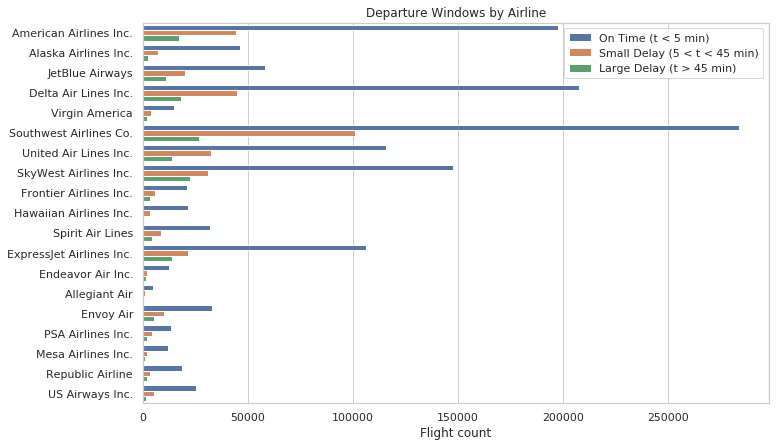

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DepDelay'].apply(delay_type)

fig = plt.figure(1, figsize=(10,7))
plt.title('Departure Windows by Airline')
ax = sns.countplot(y='Reporting_Airline', hue='DELAY_LEVEL', data=df)

labels = [airlines_lookup[item.get_text()] for item in ax.get_yticklabels()]

ax.set_yticklabels(labels)

ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count')

L = plt.legend()
L.get_texts()[0].set_text('On Time (t < 5 min)')
L.get_texts()[1].set_text('Small Delay (5 < t < 45 min)')
L.get_texts()[2].set_text('Large Delay (t > 45 min)')
plt.show()

It appears as if the number of delayed flights scales with the size of the airline and how many flights they run, as one would expect. However, what is notable here is that there's a good amount of variation in delay times *between similarly sized airlines*. Hawaiian and Frontier are both similar sizes, but Frontier has more large delays. This indicates that the airline will be an important part of the model.

Next, we'll plot the overall distribution of departure times by airline.

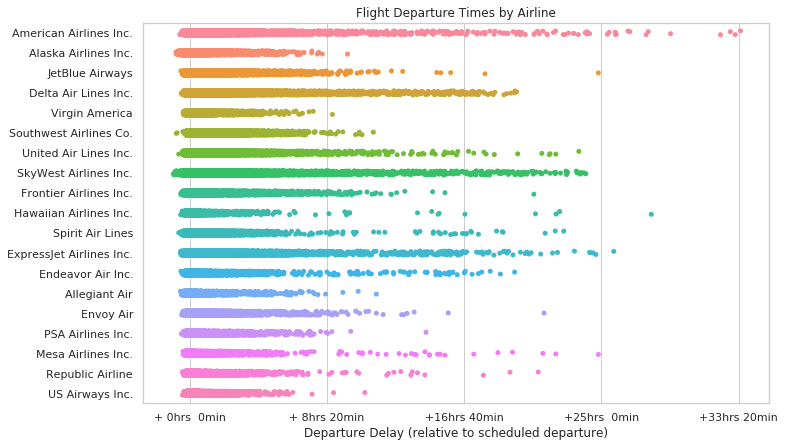

In [15]:
fig = plt.figure(1, figsize=(10,7))

plt.title('Flight Departure Times by Airline')

ax = sns.stripplot(y='Reporting_Airline', x='DepDelay', data=df)
ax.set_xticklabels(['+{:2.0f}hrs {:2.0f}min'.format(*[int(y) for y in divmod(x,60)]) for x in ax.get_xticks()])

labels = [airlines_lookup[item.get_text()] for item in ax.get_yticklabels()]

ax.set_yticklabels(labels)

plt.xlabel('Departure Time (relative to scheduled departure)')
ax.yaxis.label.set_visible(False)

plt.show()

This is a more telling visualization, as it ignores the size of the airline and just shows the overall departure time distribution for each. A tighter cluster towards the left of the graph is better, and there are clear differences between airlines once again. SkyWest, American, and Delta are of particluar note for their large distributions. 

Now let's look at the average departure and arrival times for each airline.

KeyboardInterrupt: 

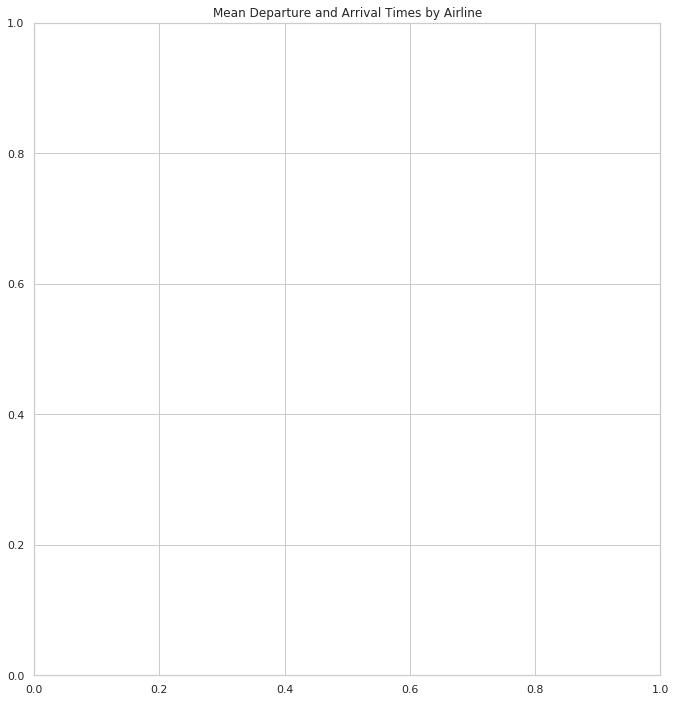

In [29]:
fig = plt.figure(1, figsize=(10,12))
plt.title('Mean Departure and Arrival Times by Airline')

dept_data = dict()
arr_data = dict()

for carrier in airlines_lookup.keys():
    delays = df[df['Reporting_Airline'] == carrier]
    del_dep = delays['DepDelay']
    del_arr = delays['ArrDelay']
    
    if del_dep.count() > 0:
        dep = del_dep.sum() / del_dep.count()
        arr = del_arr.sum() / del_arr.count()
        dept_data[carrier] = [carrier, dep, 'Departing']
        arr_data[carrier] = [carrier, arr, 'Arriving']
    
temp = []
temp.append(pd.DataFrame.from_dict(dept_data, orient='index', columns=['carrier', 'time', 'dir']))
temp.append(pd.DataFrame.from_dict(arr_data, orient='index', columns=['carrier', 'time', 'dir']))

df_temp = pd.concat(temp)

ax = sns.barplot(y='carrier', x='time', hue='dir', data=df_temp)

labels = [airlines_lookup[item.get_text()] for item in ax.get_yticklabels()]

ax.set_yticklabels(labels)

plt.xlabel('Time (relative to scheduled)')
ax.yaxis.label.set_visible(False)

L = plt.legend()
L.get_texts()[0].set_text('Departure Time')
L.get_texts()[1].set_text('Arrival Time')

plt.show()

Now let's take a look at another possibly important variable- airport.

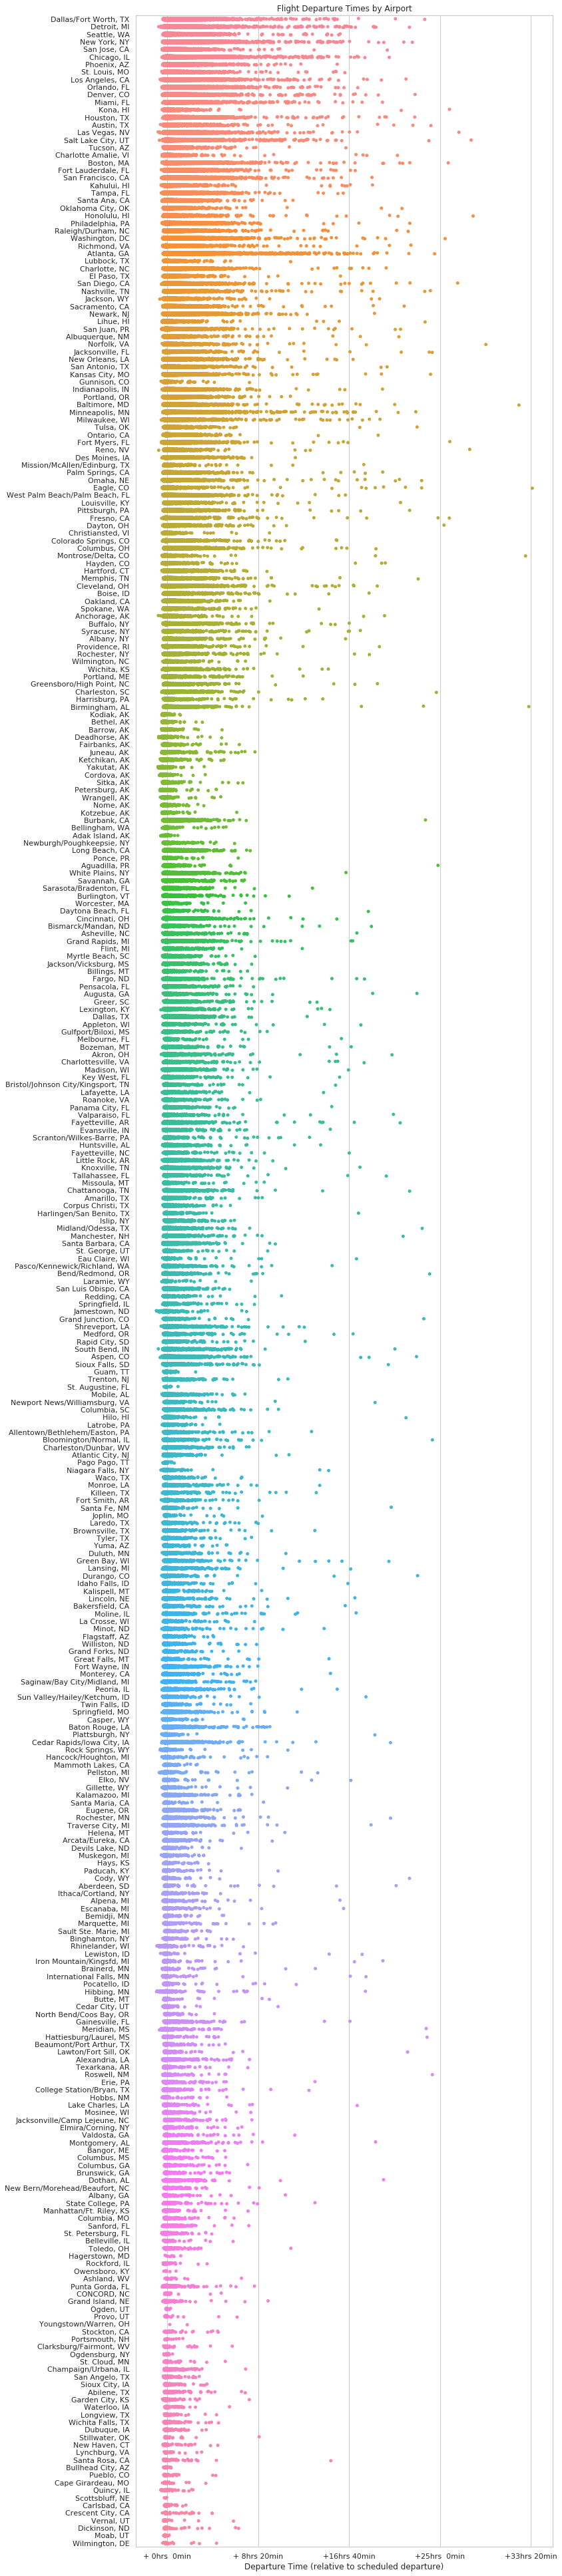

In [16]:
fig = plt.figure(1, figsize=(10,70))

plt.title('Flight Departure Times by Airport')

ax = sns.stripplot(y='OriginCityName', x='DepDelay', data=df)
ax.set_xticklabels(['+{:2.0f}hrs {:2.0f}min'.format(*[int(y) for y in divmod(x,60)]) for x in ax.get_xticks()])

plt.xlabel('Departure Time (relative to scheduled departure)')
ax.yaxis.label.set_visible(False)

plt.show()

Here we can see a similar difference between airports. Of course, this is a bit misleading since the number of flights from each airport will play a role in delays, but it shows that airport will also play an important role in the model. An interesting observation from this graph: notice that Atlanta has a larger distribution of flight departure times than Chicago. This seems unintuitive at first; Chicago is further north and must deal with more severe winter weather, which would logically lead to more delays. However, recall the distributions of Delta and United. Delta had a much larger distribution than United. Atlanta is a large hub for Delta, while Chicago is a large hub for United. Here we find an interesting case of the two variables being intertwined. 

Now, the above strip plots were a bit misleading in that they showed the entire distribution of possible flight departures, from 0 to 33 hours after scheduled departure time. Let's now take a look at when the majority of flights depart.

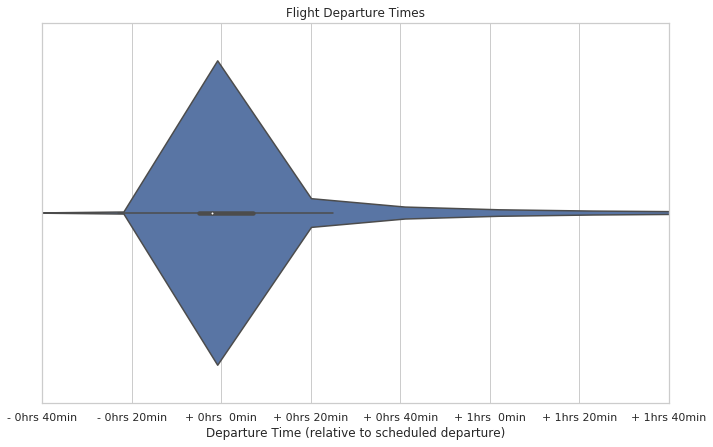

In [18]:
fig = plt.figure(1, figsize=(10,7))
sns.set(style="whitegrid")

plt.title('Flight Departure Times')
ax = sns.violinplot(x=df['DepDelay'])
plt.xlim(-40, 100)

ax.set_xticklabels(['{}{:2.0f}hrs {:2.0f}min'.format(('-' if x < 0 else '+'),
                                                     *[int(y) for y in divmod(abs(x),60)]) for x in ax.get_xticks()])
plt.xlabel('Departure Time (relative to scheduled departure)')
plt.show()

The range between -20 and +20 minutes seems to be when the majority of flights leave, with the mean slightly less than zero. It will be important to ensure that the model is most accurate in this range, rather than trying to accurately predict over the 33 hour possible scale, as anything over 2 hours can safely be consitered an outlier. 